# Modelización del precio de alquiler de una vivienda en la provincia de Valencia

![](https://archello.s3.eu-central-1.amazonaws.com/images/2021/01/29/on-a-panoramic-house-private-houses-archello.1611915827.8907.jpg)

El objetivo de este proyecto consiste en realizar una estimación fiable del precio del alquiler de una vivienda en la provincia de Valencia a partir de los atributos de cada inmueble; atributos como el número de habitaciones, el tipo de vivienda, la ubicación, etc.

Como punto de partida para nuestro análisis se utilizará los datos obtenidos gracias a la API de Idealista (el portal inmobiliario más popular en España) que nos proporciona una lista de inmuebles de la provincia de Valencia, con la información de cada inmueble, como el precio de alquiler, el número de habitaciones, el tipo de vivienda, etc. 

La utilidad de este modelo de regresión no será solo la estimación del precio de alquiler de una vivienda, sino que también servirá como una herramienta para la toma de decisiones en el momento de decidir alquilar el inmueble, ya que con este modelo podremos ver si la publicación de ese inmueble que el usuario quiere alquilar está sobrevalorado por el usuario que ha publicado ese inmueble. Sirviendo así como una herramienta para proteger al usuario en contra de la especulación de otros usuarios.

In [1]:
# Librerias necesarias para el proyecto
# =============================================================================

# Operaciones de sistema
import os
from dotenv import load_dotenv, find_dotenv
import base64
import urllib
import time
import pickle

# Tratamiento de datos
import pandas as pd
import numpy as np
import requests as rq
import json

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y modelado
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Configuración de la librería de visualización de datos
sns.set(style="whitegrid", color_codes=True, font_scale=1.5)
sns.set_context(rc={"figure.figsize": (12, 8)})

# Configuración de pandas
pd.set_option("display.max_columns", None)

# Confifuración de Warnings
import warnings
warnings.filterwarnings("ignore")

## ETL 
Lo primero que haremos es crear un proceso de ETL para obtener los datos de los inmuebles de la provincia de Valencia, la ventaja de este proceso es que no requerirá que se consulten los datos de los inmuebles de la API de Idealista, ya que 
además de que son limitadas las consultas nos permitirá a la larga poseer un historico de multiples propiedades que ya no se encontrarán en la plataforma permitiendo así que a futuro se posea más información para el análisis y modelado.

### Extracción de datos
Para la extracción de datos utilizaremos la API de Idealista, la cual nos proporciona una lista de inmuebles de la provincia de Valencia, con la información de cada inmueble, como el precio de alquiler, el número de habitaciones, el tipo de vivienda, etc.

In [2]:
# Funciones para Extraer los datos de la API
# =============================================================================

# Función para obtener el token de autenticación de la API de Idealista
def get_oauth_token():

    url = "https://api.idealista.com/oauth/token"

    load_dotenv(find_dotenv('../utils/creds.env')) 
    apikey = os.environ.get("API_KEY")
    secret = os.environ.get("SECRET")
    apikey_secret = apikey + ':' + secret

    auth = str(base64.b64encode(bytes(apikey_secret, 'utf-8')))[2:][:-1] 

    headers = {'Authorization' : 'Basic ' + auth,'Content-Type': 'application/x-www-form-urlencoded;charset=UTF-8'}
    params = urllib.parse.urlencode({'grant_type':'client_credentials'})
    content = rq.post(url,headers = headers, params=params) 
    bearer_token = json.loads(content.text)['access_token'] 

    return bearer_token

# Función para obtener los datos de la API de Idealista
def search_api(token, params):
    url = "https://api.idealista.com/3.5/es/search"

    headers = {'Content-Type': 'Content-Type: multipart/form-data;', 'Authorization' : 'Bearer ' + token} 
    content = rq.post(url, headers=headers, params=params) 
        
    print(content)
    return content

Para la extracción tenemos que tener en cuenta que las peticiones son limitadas por lo que deberemos programar un tiempo de espera y guardar los datos de manera que en caso de que no se cumplan las peticiones poder utilizar lo que ya hemos pedido.

In [3]:
# # Extraemos los datos de la API de Idealista
# # =============================================================================

# # Definimos los parámetros de búsqueda
# token = get_oauth_token()
# params = {
#     "country" : 'es',
#     "operation" : "rent",
#     "propertyType" : "homes",
#     "locationId" : "0-EU-ES-46",
#     "maxItems" : 50
# } 

# # Realizamos las peticiones a la API de Idealista
# response = search_api(token, params)
# total_pages = json.loads(response.text)['totalPages']
# df = pd.DataFrame(json.loads(response.text)["elementList"])

# for i in range(2, total_pages):
#     params['page'] = i

#     # Control de errores
#     try:
#         response = search_api(token, params)
        
#         # Unimos al DataFrame de la página anterior con la nueva página
#         new_df = pd.DataFrame(json.loads(response.text)["elementList"])
#         df = pd.concat([df, new_df])

#         # Tiempo de espera para evitar el bloqueo de la API
#         time.sleep(5)
        
#     except Exception as e:
#         print("Permission denied")
#         print(e, "Page: ", i, " of ", total_pages)

#         df.reset_index(drop=True, inplace=True)
                
#         print("Making a corrupted file")
#         df.to_csv('../data/raw/data_raw_corrupted.csv', index=False)
        
#         # Salimos del programa
#         exit()

# print("The extraction was successful")
# df.reset_index(drop=True, inplace=True)
# df.to_csv('../data/raw/data_raw.csv', index=False)

In [4]:
df = pd.read_csv('../data/raw/data_raw.csv')

Excelente! Ya tenemos los datos en bruto de los inmuebles de la provincia de Valencia, ahora vamos a tratar de convertirlos a un formato que podamos utilizar para el análisis.

### Transformación de datos
Veamos como vienen los datos en bruto...

In [5]:
df

,propertyCode,thumbnail,externalReference,numPhotos,floor,price,propertyType,operation,size,exterior,rooms,bathrooms,address,province,municipality,country,latitude,longitude,showAddress,url,description,hasVideo,status,newDevelopment,hasLift,priceByArea,detailedType,suggestedTexts,hasPlan,has3DTour,has360,hasStaging,superTopHighlight,topNewDevelopment,district,neighborhood,parkingSpace,labels
0,98616112,https://img3.idealista.com/blur/WEB_LISTING/0/...,y2103121s-dana1,9,bj,450.0,flat,rent,60.0,False,2,1,"Paseo neptuno, 100",València,Daimus,es,38.981495,-0.147183,True,https://www.idealista.com/inmueble/98616112/,Inmobiliaria Soluciones os presenta en alquile...,False,good,False,False,8.0,{'typology': 'flat'},"{'subtitle': 'Daimus', 'title': 'Piso en Paseo...",False,False,False,False,False,False,NaN,NaN,NaN,NaN
1,94355843,https://img3.idealista.com/blur/WEB_LISTING/0/...,ND JGMARX 1A,15,1,950.0,flat,rent,91.0,True,2,1,barrio Marxalenes,València,València,es,39.484394,-0.380523,False,https://www.idealista.com/inmueble/94355843/,Alquilo luminoso piso en la Calle Doctor Monto...,False,good,False,True,10.0,{'typology': 'flat'},"{'subtitle': 'Marxalenes, València', 'title': ...",False,False,False,False,False,False,La Saïdia,Marxalenes,NaN,NaN
2,98616050,https://img3.idealista.com/blur/WEB_LISTING/0/...,mca,17,9,750.0,flat,rent,93.0,True,3,1,Avenida del Cid,València,València,es,39.469281,-0.406392,False,https://www.idealista.com/inmueble/98616050/,Aska inmobiliaria dispone de esta magnifica vi...,False,good,False,True,8.0,{'typology': 'flat'},"{'subtitle': 'Tres Forques, València', 'title'...",False,False,False,False,False,False,L'Olivereta,Tres Forques,NaN,NaN
3,98615697,https://img3.idealista.com/blur/WEB_LISTING/0/...,HV - 134,27,10,2100.0,flat,rent,122.0,True,3,2,barrio Penya-Roja,València,València,es,39.458081,-0.352503,False,https://www.idealista.com/inmueble/98615697/,Para acceder a toda nuestra oferta inmobiliari...,False,good,False,True,17.0,{'typology': 'flat'},"{'subtitle': 'Penya-Roja, València', 'title': ...",True,False,False,False,False,False,Camins al Grau,Penya-Roja,"{'hasParkingSpace': True, 'isParkingSpaceInclu...",NaN
4,98615640,https://img3.idealista.com/blur/WEB_LISTING/0/...,1564110660997,17,3,1000.0,flat,rent,110.0,True,3,2,Avenida de la Malva-Rosa,València,València,es,39.480976,-0.328320,False,https://www.idealista.com/inmueble/98615640/,Este piso se encuentra en Avinguda de la Malva...,True,renew,False,False,9.0,{'typology': 'flat'},"{'subtitle': 'Playa de la Malvarrosa, València...",False,False,False,False,False,False,Poblats Marítims,Playa de la Malvarrosa,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2045,98472614,https://img3.idealista.com/blur/WEB_LISTING/0/...,W-02PXBJ,38,4,2050.0,penthouse,rent,84.0,True,1,2,Calle del Pòpul,València,València,es,39.471398,-0.377462,False,https://www.idealista.com/inmueble/98472614/,Ático para corta estancia en el centro ALQUILE...,False,good,False,True,24.0,"{'typology': 'flat', 'subTypology': 'penthouse'}","{'subtitle': 'El Mercat, València', 'title': '...",False,False,False,False,False,False,Ciutat Vella,El Mercat,NaN,NaN
2046,98472545,https://img3.idealista.com/blur/WEB_LISTING/0/...,W-02PXBS,32,1,1650.0,flat,rent,70.0,True,1,2,barrio El Mercat,València,València,es,39.472098,-0.376362,False,https://www.idealista.com/inmueble/98472545/,Estudio para corta estancia en el centro CONSU...,False,good,False,True,24.0,{'typology': 'flat'},"{'subtitle': 'El Mercat, València', 'title': '...",False,False,False,False,False,False,Ciutat Vella,El Mercat,NaN,NaN
2047,98449452,https://img3.idealista.com/blur/WEB_LISTING/0/...,W-02PW6G,21,3,1600.0,flat,rent,60.0,True,1,1,Calle dels Cabillers,València,València,es,39.473940,-0.375837,False,https://www.idealista.com/inmueble/98449452/,Exclusivo apartamento para corta estancia Cort...,False,good,False,True,27.0,{'typology': 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   propertyCode       2050 non-null   int64  
 1   thumbnail          2050 non-null   object 
 2   externalReference  1968 non-null   object 
 3   numPhotos          2050 non-null   int64  
 4   floor              1739 non-null   object 
 5   price              2050 non-null   float64
 6   propertyType       2050 non-null   object 
 7   operation          2050 non-null   object 
 8   size               2050 non-null   float64
 9   exterior           2050 non-null   bool   
 10  rooms              2050 non-null   int64  
 11  bathrooms          2050 non-null   int64  
 12  address            2050 non-null   object 
 13  province           2050 non-null   object 
 14  municipality       2050 non-null   object 
 15  country            2050 non-null   object 
 16  latitude           2050 

Bueno vemos que hemos recaudado un total de 2100 anuncios de alquileres de viviendas en la provincia de Valencia, con 38 columnas en donde algunas están mal formateadas con datos anidados en cada fila, por lo que tenemos que escoger las columnas que nos sean más utiles para como:

* **propertyCode**: Código del inmueble (Servirá como identificador del inmueble)
* **price**: Precio de alquiler del inmueble (Target)
* **numPhotos**: Número de fotos que tiene el inmueble en la web de Idealista
* **size**: Tamaño del inmueble (m2)
* **floor**: Número de planta del inmueble
* **rooms**: Número de habitaciones del inmueble
* **bathrooms**: Número de baños del inmueble
* **latitude**: Latitud del inmueble
* **longitude**: Longitud del inmueble
* **propertyType**: Tipo de vivienda del inmueble
* **parkingSpace**: Tiene datos anidados sobre si tiene o no parking y su respectivo precio
* **exterior**: Boolean que indica si el inmueble tiene o no exterior
* **hasLift**: Boolean que indica si el inmueble tiene o no ascensor
* **hasPlan**: Boolean que indica si el inmueble tiene o no plano
* **has360**: Boolean que indica si el inmueble tiene o no fotos en 360º
* **has3DTour**: Boolean que indica si el inmueble tiene o no tour 3D
* **hasVideo**: Boolean que indica si el inmueble tiene o no video
* **newDevelopmentFinished**: Boolean que indica si el inmueble está terminado o no

El resto de columnas no son necesarias para el análisis, o contienen más de un 70% de cantidad de nulos, o poseen un 90% de datos únicos o son 100% el mismo dato como en **country** que todos son 'es'.

In [7]:
# Nos quedamos con las columnas que nos interesan
cols_needed = [
    'propertyCode', 'price', 'numPhotos', 'size', 
    'floor', 'rooms', 'bathrooms', 'latitude', 'longitude', 
    'propertyType', 'parkingSpace', 'exterior', 'hasLift', 
    'hasPlan', 'has360', 'has3DTour', 'hasVideo'
    ]

df = df[cols_needed]

# Hacemos que propertyCode sea el índice
df.set_index('propertyCode', inplace=True)
df

,price,numPhotos,size,floor,rooms,bathrooms,latitude,longitude,propertyType,parkingSpace,exterior,hasLift,hasPlan,has360,has3DTour,hasVideo
propertyCode,,,,,,,,,,,,,,,,
98616112,450.0,9,60.0,bj,2,1,38.981495,-0.147183,flat,NaN,False,False,False,False,False,False
94355843,950.0,15,91.0,1,2,1,39.484394,-0.380523,flat,NaN,True,True,False,False,False,False
98616050,750.0,17,93.0,9,3,1,39.469281,-0.406392,flat,NaN,True,True,False,False,False,False
98615697,2100.0,27,122.0,10,3,2,39.458081,-0.352503,flat,"{'hasParkingSpace': True, 'isParkingSpaceInclu...",True,True,True,False,False,False
98615640,1000.0,17,110.0,3,3,2,39.480976,-0.328320,flat,NaN,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98472614,2050.0,38,84.0,4,1,2,39.471398,-0.377462,penthouse,NaN,True,True,False,False,False,False
98472545,1650.0,32,70.0,1,1,2,39.472098,-0.376362,flat,NaN,True,True,False,False,False,False
98449452,1600.0,21,60.0,3,1,1,39.473940,-0.375837,flat,NaN,True,True,False,False,False,False


Aquí podemos ver que la columna **ParkingSpace** tiene datos anidados, por lo que tenemos que extraer los datos que nos interesan.

In [8]:
import ast

df['parkingSpace'] = df['parkingSpace'].str.replace('\'', '"')
df['parkingSpace'] = df['parkingSpace'].apply(
    lambda x: ast.literal_eval(x) if type(x) == str else x
    )

df['hasParkingSpace'] = df['parkingSpace'].apply(
    lambda x: x['hasParkingSpace'] if type(x) == dict else False
    )

df['isParkingSpaceIncludedInPrice'] = df['parkingSpace'].apply(
    lambda x: x['isParkingSpaceIncludedInPrice'] if type(x) == dict else False
    )

df['parkingSpacePrice'] = df['parkingSpace'].apply(
    lambda x: x['parkingSpacePrice'] 
    if type(x) == dict and 'parkingSpacePrice' in x else 0
    )

df.drop(columns=['parkingSpace'], inplace=True)
df

,price,numPhotos,size,floor,rooms,bathrooms,latitude,longitude,propertyType,exterior,hasLift,hasPlan,has360,has3DTour,hasVideo,hasParkingSpace,isParkingSpaceIncludedInPrice,parkingSpacePrice
propertyCode,,,,,,,,,,,,,,,,,,
98616112,450.0,9,60.0,bj,2,1,38.981495,-0.147183,flat,False,False,False,False,False,False,False,False,0.0
94355843,950.0,15,91.0,1,2,1,39.484394,-0.380523,flat,True,True,False,False,False,False,False,False,0.0
98616050,750.0,17,93.0,9,3,1,39.469281,-0.406392,flat,True,True,False,False,False,False,False,False,0.0
98615697,2100.0,27,122.0,10,3,2,39.458081,-0.352503,flat,True,True,True,False,False,False,True,True,0.0
98615640,1000.0,17,110.0,3,3,2,39.480976,-0.328320,flat,True,False,False,False,False,True,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98472614,2050.0,38,84.0,4,1,2,39.471398,-0.377462,penthouse,True,True,False,False,False,False,False,False,0.0
98472545,1650.0,32,70.0,1,1,2,39.472098,-0.376362,flat,True,True,False,False,False,False,False,False,0.0
98449452,1600.0,21,60.0,3,1,1,39.473940,-0.375837,flat,True,True,False,False,False,False,False,False,0.0


In [9]:
df['floor'].value_counts()

2     367
4     246
1     205
5     165
bj    164
3     164
8     164
6     141
9      41
10     41
13     41
Name: floor, dtype: int64

Vemos que en la columna **floor** hay presencia de nulos, a los que les imputaremos la moda de dependiendo del tipo de vivienda que sea. Además hay que reformatear la columna para sea completamente numérica.

In [10]:
df['floor'][df['propertyType'] == 'chalet'].mode()

Series([], Name: floor, dtype: object)

In [11]:
floor_nan = df[df['floor'].isnull()] 
property_type = floor_nan['propertyType'].value_counts().index.to_list()

# Imputamos la moda dependiendo del tipo de propiedad
for i in property_type:
    if i == 'chalet':
        index = df[(df['propertyType'] == i) & (df['floor'].isnull())].index
        df.loc[index, 'floor'] = 0
    else:
        mode = df['floor'][df['propertyType'] == i].mode()[0]
        index = df[(df['propertyType'] == i) & (df['floor'].isnull())].index
        df.loc[index, 'floor'] = mode

# Reformateamos la columna a completamente numérica
df.loc[df['floor'] == 'bj', 'floor'] = 0
df.loc[df['floor'] == 'en', 'floor'] = 0
df.loc[df['floor'] == 'st', 'floor'] = -1

df

,price,numPhotos,size,floor,rooms,bathrooms,latitude,longitude,propertyType,exterior,hasLift,hasPlan,has360,has3DTour,hasVideo,hasParkingSpace,isParkingSpaceIncludedInPrice,parkingSpacePrice
propertyCode,,,,,,,,,,,,,,,,,,
98616112,450.0,9,60.0,0,2,1,38.981495,-0.147183,flat,False,False,False,False,False,False,False,False,0.0
94355843,950.0,15,91.0,1,2,1,39.484394,-0.380523,flat,True,True,False,False,False,False,False,False,0.0
98616050,750.0,17,93.0,9,3,1,39.469281,-0.406392,flat,True,True,False,False,False,False,False,False,0.0
98615697,2100.0,27,122.0,10,3,2,39.458081,-0.352503,flat,True,True,True,False,False,False,True,True,0.0
98615640,1000.0,17,110.0,3,3,2,39.480976,-0.328320,flat,True,False,False,False,False,True,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98472614,2050.0,38,84.0,4,1,2,39.471398,-0.377462,penthouse,True,True,False,False,False,False,False,False,0.0
98472545,1650.0,32,70.0,1,1,2,39.472098,-0.376362,flat,True,True,False,False,False,False,False,False,0.0
98449452,1600.0,21,60.0,3,1,1,39.473940,-0.375837,flat,True,True,False,False,False,False,False,False,0.0


Continuamos con el procesamiento de la columna **HasLift**, que posee datos nulos también por lo que asumiremos que los que no son *True* pues son *False*.

In [12]:
index = df[df['hasLift'].isnull()].index
df.loc[index, 'hasLift'] = False
df

,price,numPhotos,size,floor,rooms,bathrooms,latitude,longitude,propertyType,exterior,hasLift,hasPlan,has360,has3DTour,hasVideo,hasParkingSpace,isParkingSpaceIncludedInPrice,parkingSpacePrice
propertyCode,,,,,,,,,,,,,,,,,,
98616112,450.0,9,60.0,0,2,1,38.981495,-0.147183,flat,False,False,False,False,False,False,False,False,0.0
94355843,950.0,15,91.0,1,2,1,39.484394,-0.380523,flat,True,True,False,False,False,False,False,False,0.0
98616050,750.0,17,93.0,9,3,1,39.469281,-0.406392,flat,True,True,False,False,False,False,False,False,0.0
98615697,2100.0,27,122.0,10,3,2,39.458081,-0.352503,flat,True,True,True,False,False,False,True,True,0.0
98615640,1000.0,17,110.0,3,3,2,39.480976,-0.328320,flat,True,False,False,False,False,True,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98472614,2050.0,38,84.0,4,1,2,39.471398,-0.377462,penthouse,True,True,False,False,False,False,False,False,0.0
98472545,1650.0,32,70.0,1,1,2,39.472098,-0.376362,flat,True,True,False,False,False,False,False,False,0.0
98449452,1600.0,21,60.0,3,1,1,39.473940,-0.375837,flat,True,True,False,False,False,False,False,False,0.0


In [13]:
# ¿Hay presencia de nulos?
df.isnull().sum()

price                            0
numPhotos                        0
size                             0
floor                            0
rooms                            0
bathrooms                        0
latitude                         0
longitude                        0
propertyType                     0
exterior                         0
hasLift                          0
hasPlan                          0
has360                           0
has3DTour                        0
hasVideo                         0
hasParkingSpace                  0
isParkingSpaceIncludedInPrice    0
parkingSpacePrice                0
dtype: int64

Pues ya terminamos el procesamiento de columnas, para continuar tenemos que asegurarnos que nuestras columnas tienen formato/tipo correcto para poder utilizarlas en el análisis.

In [14]:
# int types
df['numPhotos'] = df['numPhotos'].astype(int)
df['floor'] = df['floor'].astype(int)
df['rooms'] = df['rooms'].astype(int)
df['bathrooms'] = df['bathrooms'].astype(int)

# float types
df['price'] = df['price'].astype(float)
df['size'] = df['size'].astype(float)
df['parkingSpacePrice'] = df['parkingSpacePrice'].astype(float)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)

# boolean types
df['exterior'] = df['exterior'].astype(bool)
df['hasParkingSpace'] = df['hasParkingSpace'].astype(bool)
df['isParkingSpaceIncludedInPrice'] = df['isParkingSpaceIncludedInPrice'].astype(bool)
df['hasLift'] = df['hasLift'].astype(bool)
df['hasPlan'] = df['hasPlan'].astype(bool)
df['has360'] = df['has360'].astype(bool)
df['has3DTour'] = df['has3DTour'].astype(bool)
df['hasVideo'] = df['hasVideo'].astype(bool)

# object types
df['propertyType'] = df['propertyType'].astype(str)

order_of_cols = [
    'price', 'numPhotos', 'floor', 'rooms', 'bathrooms', 'size', 
    'parkingSpacePrice', 'latitude', 'longitude', 'exterior', 
    'hasParkingSpace', 'isParkingSpaceIncludedInPrice', 
    'hasLift', 'hasPlan', 'has360', 'has3DTour', 'hasVideo',
    'propertyType'
    ]
            
df = df[order_of_cols]
df

,price,numPhotos,floor,rooms,bathrooms,size,parkingSpacePrice,latitude,longitude,exterior,hasParkingSpace,isParkingSpaceIncludedInPrice,hasLift,hasPlan,has360,has3DTour,hasVideo,propertyType
propertyCode,,,,,,,,,,,,,,,,,,
98616112,450.0,9,0,2,1,60.0,0.0,38.981495,-0.147183,False,False,False,False,False,False,False,False,flat
94355843,950.0,15,1,2,1,91.0,0.0,39.484394,-0.380523,True,False,False,True,False,False,False,False,flat
98616050,750.0,17,9,3,1,93.0,0.0,39.469281,-0.406392,True,False,False,True,False,False,False,False,flat
98615697,2100.0,27,10,3,2,122.0,0.0,39.458081,-0.352503,True,True,True,True,True,False,False,False,flat
98615640,1000.0,17,3,3,2,110.0,0.0,39.480976,-0.328320,True,False,False,False,False,False,False,True,flat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98472614,2050.0,38,4,1,2,84.0,0.0,39.471398,-0.377462,True,False,False,True,False,False,False,False,penthouse
98472545,1650.0,32,1,1,2,70.0,0.0,39.472098,-0.376362,True,False,False,True,False,False,False,False,flat
98449452,1600.0,21,3,1,1,60.0,0.0,39.473940,-0.375837,True,False,False,True,False,False,False,False,flat


Ahora vamos a ver la presencia de outliers en nuestro conjunto de datos, para eso utilizaremos una librería que nos permitirá ver el porcentaje de outliers que hay en nuestro dataset mediante el algoritmo de K-Nearest Neighbors (KNN).

In [15]:
from pyod.models.knn import KNN

num_cols = df.select_dtypes(include=['int64', 'float64']).columns
            
clf = KNN()
clf.fit(df[num_cols])
y_pred = clf.predict(df[num_cols])

print(f'The percentage of outliers is {100*sum(y_pred)/len(y_pred)}%')

The percentage of outliers is 0.0%


Pues podemos seguir adelante sabiendo que nuestro dataset no posee datos que no afecten el resultado de nuestro modelo de regresión.

Para finalizar el proceso de transformación transformaremos nuestras columnas **latitude** y **longitude** a información mejor interpretable para el análisis y modelado, para eso utilizaremos el algoritmo de K-Means que creará clusters en base a la información de las coordenadas haciendo así que cada cluster represente una zona geográfica y así poder analizar los inmuebles de una manera más sencilla.

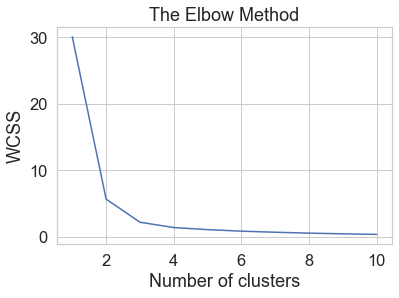

In [16]:
# Datos con los que trabajaremos
X = df[['latitude', 'longitude']]

# Metodo Elbow 
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Aquí podemos ver que para este set de datos se pueden localizar dos clusters claramente separados y hasta un máximo de 4 clusters donde a partir de cuatro no se pueden ver diferencias significativas en la cantidad de agrupamientos por lo que trabajaremos con un máximo de 4 clusters.

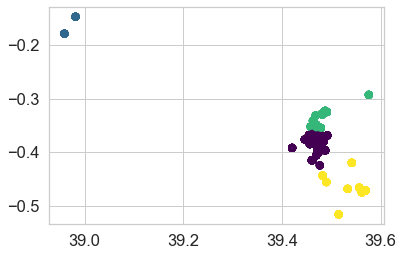

In [17]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
labels = kmeans.fit_predict(X)
X['cluster_label'] = labels

# Visualizamos los clusters
plt.scatter(X['latitude'], X['longitude'], c=X['cluster_label'], s=50, cmap='viridis')
plt.show()

Vemos que en este dataset especifíco la mayoría de los anuncios están posicionados en dos áreas especificas, y 4 anuncios están están en dos áreas muy lejanas, por lo que esto se puede interpretar como que existe un grupo (aquí representado con el color morado) de anuncios que se encuentran agrupados en una zona geografica donde posiblemente esté sea grupo sea el centro de la ciudad de Valencia y el resto sean los alrededores de la ciudad pero que pertenecen a la provincia de Valencia.

In [18]:
# Añadimos esta información a nuestro dataframe
kmeas = pickle.load(open('../models/kmeans_clustering.pkl', 'rb'))
df['direction'] = kmeas.predict(df[['latitude', 'longitude']])
df['direction'] = df['direction'].map({0: 'central', 1: 'south', 2: 'north', 3: 'west'})
df.drop(columns=['latitude', 'longitude'], inplace=True)
df

,price,numPhotos,floor,rooms,bathrooms,size,parkingSpacePrice,exterior,hasParkingSpace,isParkingSpaceIncludedInPrice,hasLift,hasPlan,has360,has3DTour,hasVideo,propertyType,direction
propertyCode,,,,,,,,,,,,,,,,,
98616112,450.0,9,0,2,1,60.0,0.0,False,False,False,False,False,False,False,False,flat,south
94355843,950.0,15,1,2,1,91.0,0.0,True,False,False,True,False,False,False,False,flat,central
98616050,750.0,17,9,3,1,93.0,0.0,True,False,False,True,False,False,False,False,flat,central
98615697,2100.0,27,10,3,2,122.0,0.0,True,True,True,True,True,False,False,False,flat,central
98615640,1000.0,17,3,3,2,110.0,0.0,True,False,False,False,False,False,False,True,flat,central
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98472614,2050.0,38,4,1,2,84.0,0.0,True,False,False,True,False,False,False,False,penthouse,central
98472545,1650.0,32,1,1,2,70.0,0.0,True,False,False,True,False,False,False,False,flat,central
98449452,1600.0,21,3,1,1,60.0,0.0,True,False,False,True,False,False,False,False,flat,central


Pues ya tenemos nuestros datos transformados y listos para guardarse en un archivo csv para utilizarlo en el análisis y modelado de datos.

### Carga de datos

Este es el ultimo paso de nuestro proceso de ETL donde vamos a unificar los datos previamente procesados y obtenidos de la API de Idealista con antiguos datos que se hayan procesado previamente así creando un nuevo dataset que esté no solo con anuncios actuales sino también con anuncios anteriores que sirven para nuestro análisis y modelado.

In [19]:
processed = pd.read_csv('../data/processed/rent_Valencia.csv', index_col=0)
# ¿Cuales son las columnas distintas entre processed y df?
processed.columns.difference(df.columns)

Index([], dtype='object')

Aquí podemos ver que nuestro dataset historico tiene la misma cantidad de columnas que nuestro dataset actual, por lo que podemos unificar los datos de ambos datasets y eliminar los duplicados.

In [20]:
df = pd.concat([df, processed])

# ¿Hay duplicados?
df.duplicated().sum()

2050

Pues ya vemos que la mayoría de anuncios se encontraban ya en nuestro dataset historico, por lo que los eliminamos y añadimos los nuevos anuncios a nuestro dataset historico.

In [21]:
df.drop_duplicates(inplace=True)
df

,price,numPhotos,floor,rooms,bathrooms,size,parkingSpacePrice,exterior,hasParkingSpace,isParkingSpaceIncludedInPrice,hasLift,hasPlan,has360,has3DTour,hasVideo,propertyType,direction
propertyCode,,,,,,,,,,,,,,,,,
98616112,450.0,9,0,2,1,60.0,0.0,False,False,False,False,False,False,False,False,flat,south
94355843,950.0,15,1,2,1,91.0,0.0,True,False,False,True,False,False,False,False,flat,central
98616050,750.0,17,9,3,1,93.0,0.0,True,False,False,True,False,False,False,False,flat,central
98615697,2100.0,27,10,3,2,122.0,0.0,True,True,True,True,True,False,False,False,flat,central
98615640,1000.0,17,3,3,2,110.0,0.0,True,False,False,False,False,False,False,True,flat,central
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97433173,625.0,6,1,1,1,60.0,0.0,True,False,False,True,False,False,False,False,flat,central
97428394,600.0,4,2,0,1,78.0,0.0,True,False,False,True,False,False,False,False,studio,central
94396615,600.0,9,4,1,1,45.0,0.0,True,False,False,True,False,False,False,False,flat,central


In [22]:
df.to_csv('../data/processed/rent_Valencia.csv')

## Exploración de datos

### Variable target

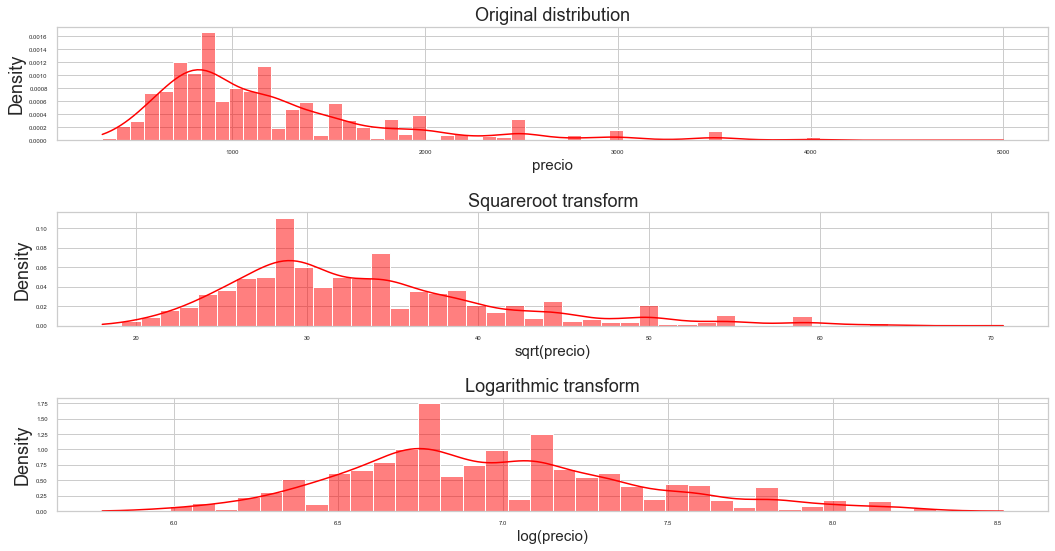

In [23]:
# Graphs of distribution of rent prices
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,8))

sns.histplot(df['price'], kde=True, stat='density', ax=axes[0], color='red')
axes[0].set_title("Original distribution", fontsize = 'medium')
axes[0].set_xlabel('precio', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.histplot(np.sqrt(df['price']), kde=True, stat='density', ax=axes[1], color='red')
axes[1].set_title("Squareroot transform", fontsize = 'medium')
axes[1].set_xlabel('sqrt(precio)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.histplot(np.log(df['price']), kde=True, stat='density', ax=axes[2], color='red')
axes[2].set_title("Logarithmic transform", fontsize = 'medium')
axes[2].set_xlabel('log(precio)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

In [24]:
# Kurtosis and Skewness
# =============================================================================
kurtosis = df['price'].kurtosis()
print(f"Kurtosis = {kurtosis:.2f}")

skewness = df['price'].skew()
print(f"Skewness = {skewness:.2f}")

Kurtosis = 4.19
Skewness = 1.85


In [25]:
from fitter import Fitter, get_common_distributions
distribuciones = get_common_distributions()

fitter = Fitter(df['price'], distributions=distribuciones)
fitter.fit()
fitter.summary(Nbest=10, plot=False)

,sumsquare_error,aic,bic,kl_div
lognorm,0.000004,2005.108399,-88586.854314,inf
gamma,0.000004,2097.543799,-88231.661715,inf
chi2,0.000004,2086.325073,-88199.483512,inf
cauchy,0.000005,2010.287615,-87944.878643,inf
rayleigh,0.000006,2366.831428,-87078.194835,inf
norm,0.000007,2517.678095,-86173.861497,inf
exponpow,0.000007,2239.714545,-86075.703638,inf
expon,0.000009,1898.895713,-84983.311728,inf
powerlaw,0.000013,1730.882470,-83438.885684,inf
uniform,0.000014,1693.996888,-83155.465314,inf


Vemos que la distribución de la variable precio no es de una distribución normal, por lo que debemos de transformar nuestra variable precio a una distribución normal para poder analizarla y eso lo hacemos con la transformación de Box-Cox.

### Variables numéricas	

In [26]:
df.describe()

,price,numPhotos,floor,rooms,bathrooms,size,parkingSpacePrice
count,4257.000000,4257.000000,4257.000000,4257.000000,4257.000000,4257.000000,4257.000000
mean,1185.238901,23.152455,3.161616,2.753347,1.654921,107.745642,0.855062
std,619.259840,12.220273,2.744047,1.121288,0.692006,52.896894,9.370927
min,325.000000,0.000000,-1.000000,0.000000,0.000000,17.000000,0.000000
25%,800.000000,15.000000,1.000000,2.000000,1.000000,77.000000,0.000000
50%,1000.000000,21.000000,3.000000,3.000000,2.000000,98.000000,0.000000
75%,1400.000000,30.000000,5.000000,3.000000,2.000000,120.000000,0.000000
max,5000.000000,104.000000,22.000000,15.000000,15.000000,690.000000,150.000000


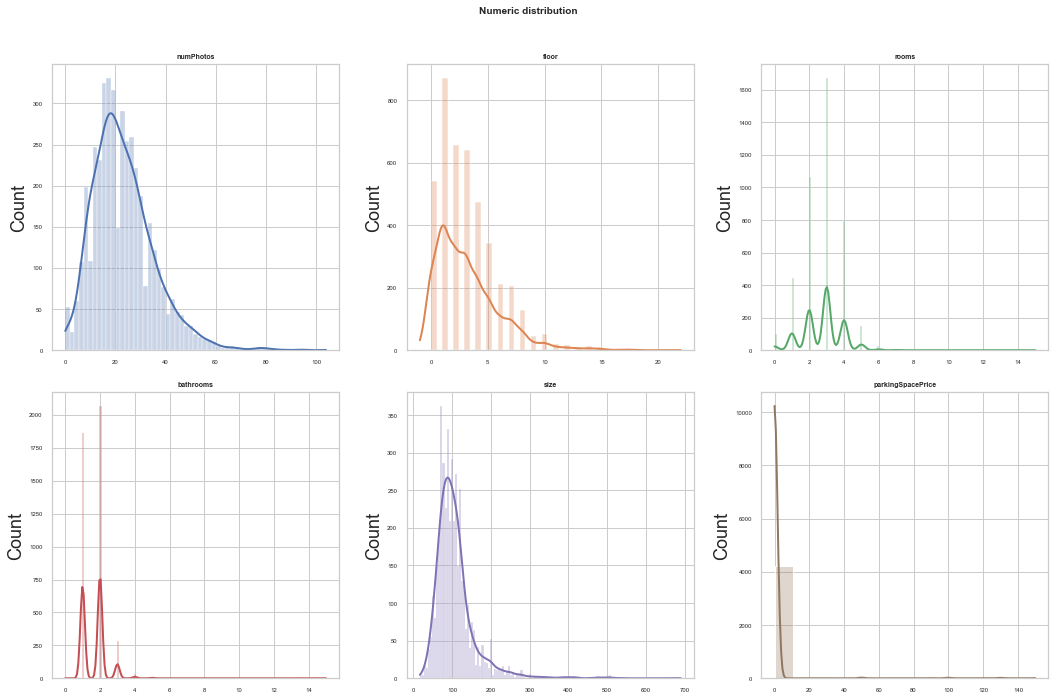

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flat
columns_numeric = df.select_dtypes(include=['float64', 'int']).columns
columns_numeric = columns_numeric.drop(['price'])

for i, col in enumerate(columns_numeric):
    sns.histplot(
        df[col],
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(col, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Numeric distribution', fontsize = 10, fontweight = "bold");

Aquí podemos ver que la mayoría de los anuncios tienen un promedio de 20 fotos, están entre la planta baja y el piso 5, poseen por lo menos entre 2 y 4 habitaciones y 1 o 2 cuartos de baño y alrededor de 100 metros cuadrados en promedio.

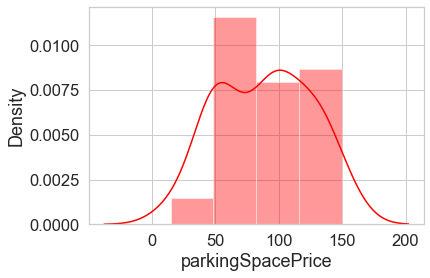

In [28]:
# parkingSpacePrice donde hasParkingSpace = True y isParkingSpaceIncludedInPrice = False
# =============================================================================
df_parking = df[df['hasParkingSpace'] == True]
df_parking = df_parking[df_parking['isParkingSpaceIncludedInPrice'] == False]
sns.distplot(df_parking['parkingSpacePrice'], kde=True, color='red')
plt.show()

Y vemos que en caso de tener que pagar por un lugar donde aparcar el coche, el precio promedio se encuentre entre 50 y 150 euros.

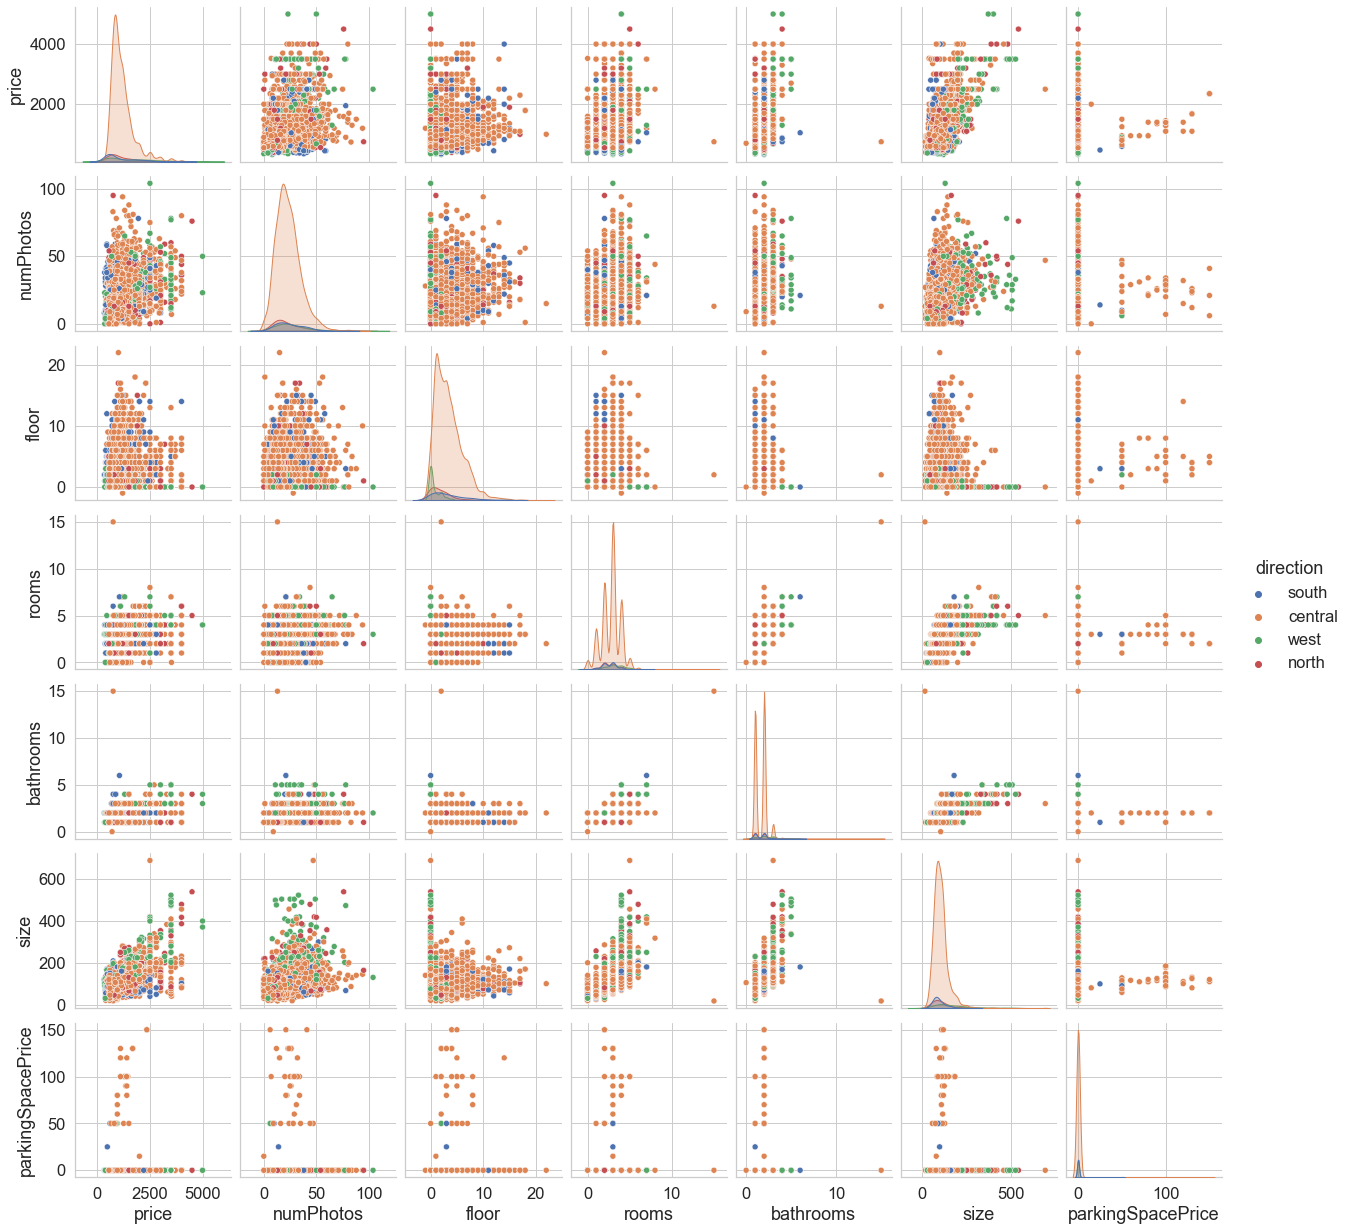

In [29]:
df_numeric = df.select_dtypes(include=['float64', 'int'])
df_numeric['direction'] = df['direction']
df_numeric.reset_index(inplace=True)
df_numeric.drop(columns=['propertyCode'], inplace=True)

sns.pairplot(df_numeric, hue='direction')
plt.show()

Parece que en la mayoría de anuncios donde hay que pagar por un lugar donde aparcar el coche es en la ciudad de Valencia

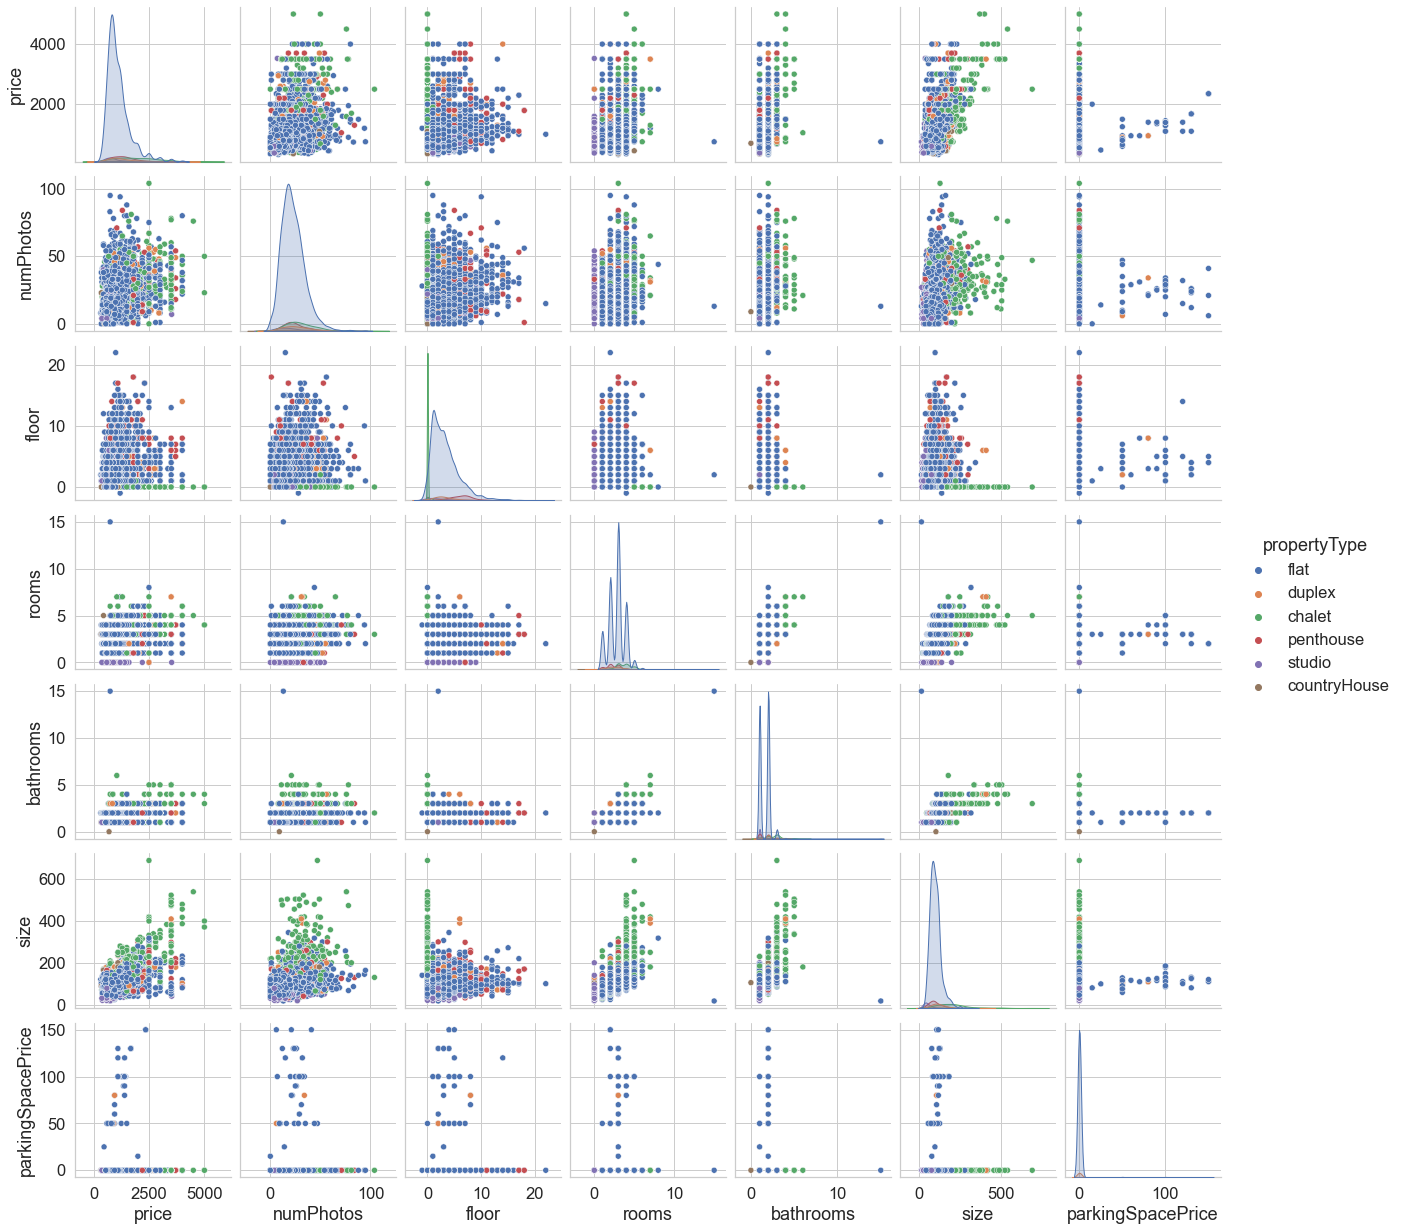

In [30]:
df_numeric['propertyType'] = df['propertyType'].reset_index(drop=True)
sns.pairplot(df_numeric, hue='propertyType')
plt.show()

vemos que hay una fuerte presencia de pisos en los anuncios de Idealista, también podemos ver que la mayoría de los anuncios en los que hay que pagar para aparcar el coche son pisos. Y que evidentemente el tipo de propiedad más grande y costosa son los chalet.

In [31]:
# Correlation matrix
# ==============================================================================
def tidy_corr_matrix(corr_mat):
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = df.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
39,size,bathrooms,0.659285,0.659285
33,bathrooms,size,0.659285,0.659285
26,rooms,size,0.573621,0.573621
38,size,rooms,0.573621,0.573621
5,price,size,0.564069,0.564069
35,size,price,0.564069,0.564069
25,rooms,bathrooms,0.561311,0.561311
31,bathrooms,rooms,0.561311,0.561311
4,price,bathrooms,0.457183,0.457183
28,bathrooms,price,0.457183,0.457183


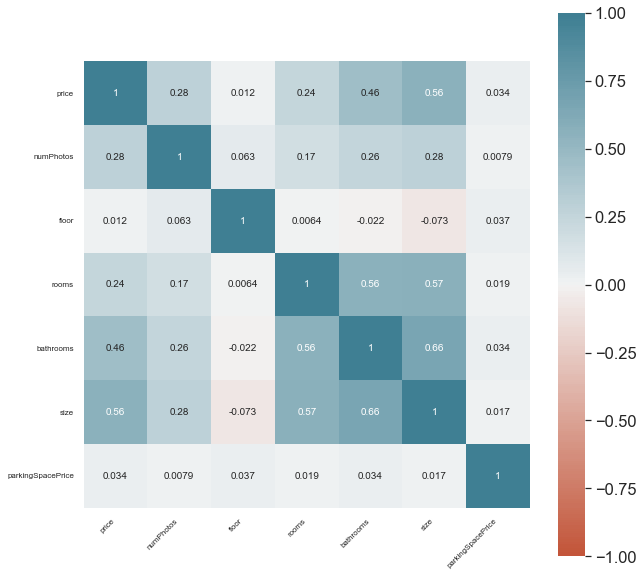

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = True,
    annot_kws = {"size": 10},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

Aquí vemos que la variable mayormente correlacionada con el precio es la variable **size** que representa la cantidad de metros cuadrados de la propiedad. La mayoría de las correlaciones son positivas y no superar el 70% de correlación por lo que podemos estar seguros con respecto al problema de la colinealidad.

### Variables categóricas

In [33]:
df.select_dtypes(include=['object', 'bool']).describe()

,exterior,hasParkingSpace,isParkingSpaceIncludedInPrice,hasLift,hasPlan,has360,has3DTour,hasVideo,propertyType,direction
count,4257,4257,4257,4257,4257,4257,4257,4257,4257,4257
unique,2,2,2,2,2,2,2,2,6,4
top,True,False,False,True,False,False,False,False,flat,central
freq,3732,3176,3217,3162,3649,4157,4207,3396,3488,3511


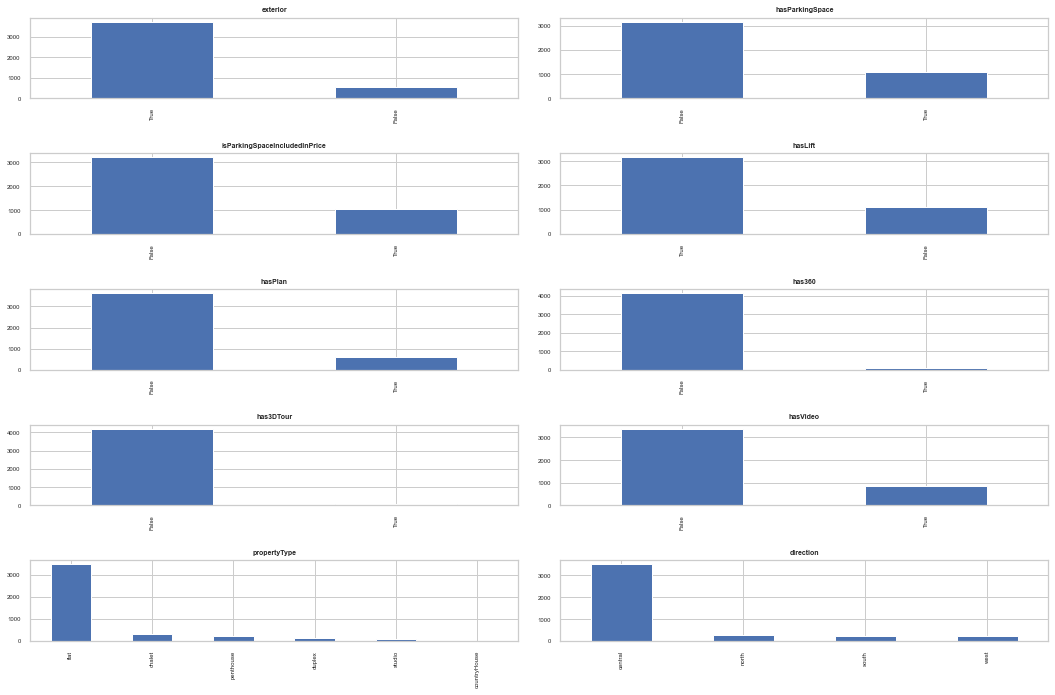

In [34]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 10))
axes = axes.flat
df_cat = df.select_dtypes(include=['object', 'bool']).columns

for i, col in enumerate(df_cat):
    df[col].value_counts().plot.bar(ax = axes[i])
    axes[i].set_title(col, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")

fig.tight_layout();

Aquí vemos que la mayoría de los anuncios son pisos, ubicados en la ciudad de Valencia, tienen un ascensor, no tienen lugar de aparcamiento y poseen exterior.

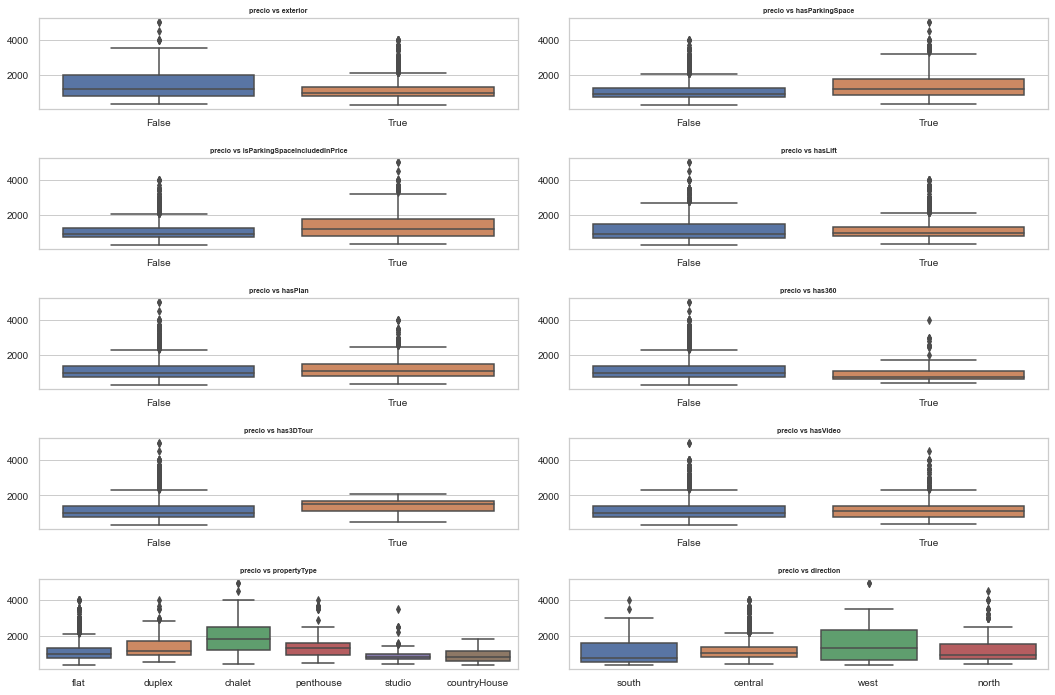

In [35]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 10))
axes = axes.flat
df_cat = df.select_dtypes(include=['object', 'bool']).columns

for i, col in enumerate(df_cat):
    sns.boxplot(
        x     = col,
        y     = 'price',
        data  = df,
        ax    = axes[i]
    )
    axes[i].set_title(f"precio vs {col}", fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

fig.tight_layout();

Parece que la segunda localidad más costosa es el oeste de la ciudad de Valencia, y que los anuncios más costosos son los que tienen el aparcamiento incluido dentro del precio de la propiedad.

## Preprocesamiento de datos 

Para el procesamiento de los datos nos valdremos de las librerias de scikit-learn para construir un preprocesador de datos que nos permita transformar nuestros datos a voluntad.

In [36]:
# Train test split
# ==============================================================================
from sklearn.model_selection import train_test_split
X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(
    X, 
    y, 
    df.index,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
    )

# Selección de las variables por típo
# ==============================================================================
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
bool_features = X_train.select_dtypes(include=['bool']).columns

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                        ]
                      )


# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[
                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))
                            ]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

# Convertir el output en dataframe y añadir el nombre de las columnas
# ==============================================================================

encoded_cat = preprocessor.named_transformers_['cat']['onehot']\
              .get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat, bool_features])
df_train_prep = preprocessor.transform(X_train)
df_train_prep = pd.DataFrame(df_train_prep, columns=labels, index=train_index)
df_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3405 entries, 98309021 to 98292386
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   numPhotos                      3405 non-null   float64
 1   floor                          3405 non-null   float64
 2   rooms                          3405 non-null   float64
 3   bathrooms                      3405 non-null   float64
 4   size                           3405 non-null   float64
 5   parkingSpacePrice              3405 non-null   float64
 6   propertyType_chalet            3405 non-null   float64
 7   propertyType_countryHouse      3405 non-null   float64
 8   propertyType_duplex            3405 non-null   float64
 9   propertyType_flat              3405 non-null   float64
 10  propertyType_penthouse         3405 non-null   float64
 11  propertyType_studio            3405 non-null   float64
 12  direction_central              3405 n

In [37]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['numPhotos', 'floor', 'rooms', 'bathrooms',
                                  'size', 'parkingSpacePrice']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['propertyType', 'direction'])])

Y para nuestra 'target' contruiremos una función que nos permita transformar nuestra variable a través del metodo de Box-Cox.

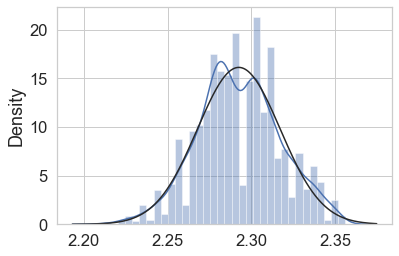

In [38]:
# Preprocesamiento de nuestra target
# ==============================================================================
import scipy.stats as stats
from scipy.special import boxcox, inv_boxcox

# Function to Box-Cox transform a column
def box_cox_transform(column, lamda= None):
    if lamda is None:
        column, lamda = stats.boxcox(column)
        
        return column, lamda
    else:
        column = boxcox(column, lamda)
        return column

def inv_box_cox_transform(column, lamda):
    column = inv_boxcox(column, lamda)
    return column

y_train_prep, lamda = box_cox_transform(y_train)

sns.distplot(y_train_prep, fit=stats.norm);

## Modelado de datos

Para el modelado de datos probaremos con todos los modelos de regresión que están implementados en las librerias de scikit-learn.

In [39]:
# Modelos de regresión
# ==============================================================================
from sklearn.utils import all_estimators
from sklearn.model_selection import cross_validate

estimators = all_estimators(type_filter='regressor')
all_regs = []

for name, RegressorClass in estimators:
    try:
        reg = RegressorClass()
        all_regs.append(reg)
    except Exception as e:
        pass

def models_metrics(list_reg, X, y):

    models_metrics = {
        'Model': [],
        'fit_time': [],
        'score_time': [],
        'test_neg_rmse': [],
        'train_neg_rmse': [],
        'test_r2': [],
        'train_r2': [],
        'test_mae': [],
        'train_mae': []
        }

    # Train the models
    for i in list_reg:

        try:
            if i.__class__.__name__ == 'QuantileRegressor':
                raise Exception('QuantileRegressor')
                
            cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
            cv_scores = cross_validate(
                estimator=i,
                X=X,
                y=y,
                scoring=['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error'],
                cv=cv,
                return_train_score=True,
                n_jobs=-1
            )

            models_metrics['Model'].append(i)
            models_metrics['fit_time'].append(cv_scores['fit_time'].mean())
            models_metrics['score_time'].append(cv_scores['score_time'].mean())
            models_metrics['test_neg_rmse'].append(cv_scores['test_neg_root_mean_squared_error'].mean())
            models_metrics['train_neg_rmse'].append(cv_scores['train_neg_root_mean_squared_error'].mean())
            models_metrics['test_r2'].append(cv_scores['test_r2'].mean())
            models_metrics['train_r2'].append(cv_scores['train_r2'].mean())
            models_metrics['test_mae'].append(cv_scores['test_neg_mean_absolute_error'].mean())
            models_metrics['train_mae'].append(cv_scores['train_neg_mean_absolute_error'].mean())
        
        except Exception as e:
            pass

    return pd.DataFrame(models_metrics)

models_metrics(all_regs, X_train_prep, y_train_prep).sort_values(by='test_neg_rmse', ascending=False)

,Model,fit_time,score_time,test_neg_rmse,train_neg_rmse,test_r2,train_r2,test_mae,train_mae
13,HistGradientBoostingRegressor(),0.783312,0.011002,-0.018841,-0.013881,0.418335,0.685195,-0.014259,-0.010571
35,RandomForestRegressor(),0.903806,0.026809,-0.019095,-0.007196,0.402741,0.915380,-0.014192,-0.005314
12,GradientBoostingRegressor(),0.251588,0.002067,-0.019161,-0.017595,0.398607,0.494181,-0.014589,-0.013459
9,ExtraTreesRegressor(),0.828522,0.030608,-0.019767,-0.001354,0.359554,0.996950,-0.014337,-0.000205
2,BaggingRegressor(),0.097889,0.006202,-0.019914,-0.008414,0.350209,0.884293,-0.014792,-0.005852
22,LassoLarsCV(),0.069214,0.001136,-0.019981,-0.019832,0.346247,0.357424,-0.015410,-0.015293
24,LinearRegression(),0.004399,0.000934,-0.019981,-0.019832,0.346247,0.357424,-0.015410,-0.015293
41,TransformedTargetRegressor(),0.007400,0.001267,-0.019981,-0.019832,0.346247,0.357424,-0.015410,-0.015293
36,Ridge(),0.001800,0.000733,-0.019983,-0.019835,0.346138,0.357267,-0.015413,-0.015295
23,LassoLarsIC(),0.014200,0.001068,-0.019986,-0.019833,0.345933,0.357351,-0.015418,-0.015294


Vemos que los mejores modelos son Random Forest Regressor y una variación del Gradient Boosting Regressor llamado Hist Gradient Boosting Regressor.

## Optimización de los hipérparametros

### Hist Gradient Boosting Regressor

* Max depth: [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

Valor óptimo de max_depth: 21


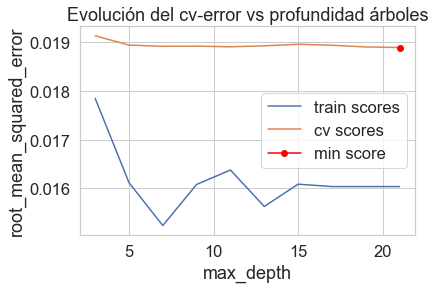

In [40]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

train_scores = []
cv_scores    = []

# Valores evaluados
max_depths = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, None]

# Bucle para entrenar un modelo con cada valor de max_depth y extraer su error
# de entrenamiento y de k-cross-validation.
for max_depth in max_depths:
    
    modelo = HistGradientBoostingRegressor(
        max_iter=1000,
        early_stopping=True,
        loss='squared_error',
        validation_fraction = 0.1,
        n_iter_no_change    = 10,
        tol                 = 1e-7,
        random_state        = 42,
        max_depth=max_depth
        )
    
    # Error de train
    modelo.fit(X_train_prep, y_train_prep)
    predicciones = modelo.predict(X = X_train_prep)
    rmse = mean_squared_error(
            y_true  = y_train_prep,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train_prep,
                y         = y_train_prep,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = -1
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_depths, train_scores, label="train scores")
ax.plot(max_depths, cv_scores, label="cv scores")
ax.plot(max_depths[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_depth")
ax.set_title("Evolución del cv-error vs profundidad árboles")
plt.legend();
print(f"Valor óptimo de max_depth: {max_depths[np.argmin(cv_scores)]}")

In [41]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'loss'             : ['squared_error', 'absolute_error'],
              'learning_rate'    : [0.0001, 0.001, 0.01, 0.1],
              'max_depth'        : [None, 6 , 7, 8, 12, 21, 22],
              'l2_regularization': [0, 1]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = HistGradientBoostingRegressor(
                        max_iter            = 1000,
                        # Activación de la parada temprana
                        early_stopping      = True,
                        scoring             = 'loss',
                        validation_fraction = 0.1,
                        n_iter_no_change    = 10,
                        tol                 = 1e-7,
                        random_state        = 42
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = -1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_prep, y = y_train_prep)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head()

,param_l2_regularization,param_learning_rate,param_loss,param_max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
102,1,0.1,squared_error,12,-0.018949,0.000481,-0.015606,0.000429
104,1,0.1,squared_error,22,-0.018950,0.000476,-0.015306,0.000660
103,1,0.1,squared_error,21,-0.018951,0.000478,-0.015299,0.000671
98,1,0.1,squared_error,None,-0.018953,0.000480,-0.015331,0.000622
101,1,0.1,squared_error,8,-0.018965,0.000497,-0.015808,0.000588


In [42]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

# Número de árboles del modelo final (early stopping)
# ==============================================================================
print(f"Número de árboles del modelo: {grid.best_estimator_.n_iter_}")

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'l2_regularization': 1, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 12} : -0.018948893876394445 neg_root_mean_squared_error
Número de árboles del modelo: 54


In [43]:
# Error de test del modelo final
# ==============================================================================
modelo_histgb = grid.best_estimator_
y_pred = modelo_histgb.predict(X = X_test_prep)
y_pred = inv_box_cox_transform(y_pred, lamda)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 483.08449943101954


### Random Forest Regressor

* Número de arboles: range(1, 1000, 5)
* Max features: range(1, X_train.shape[1] + 1, 1)
* Max depth: [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, None]

Valor óptimo de n_estimators: 876


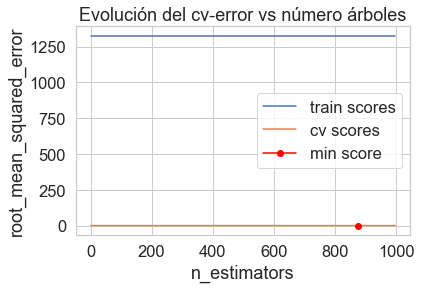

In [44]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 1000, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'mse',
                max_depth    = None,
                max_features = 'auto',
                oob_score    = False,
                n_jobs       = -1,
                random_state = 42
             )
    
    # Error de train
    modelo.fit(X_train_prep, y_train_prep)
    predicciones = modelo.predict(X = X_train_prep)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train_prep,
                y         = y_train_prep,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

Valor óptimo de max_features: 6


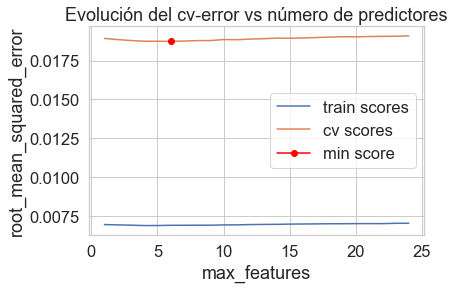

In [45]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_features_range = range(1, X_train_prep.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:
    
    modelo = RandomForestRegressor(
                n_estimators = 796,
                criterion    = 'mse',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 42
             )
    
    # Error de train
    modelo.fit(X_train_prep, y_train_prep)
    predicciones = modelo.predict(X = X_train_prep)
    rmse = mean_squared_error(
            y_true  = y_train_prep,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train_prep,
                y         = y_train_prep,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

Valor óptimo de max_depth: 15


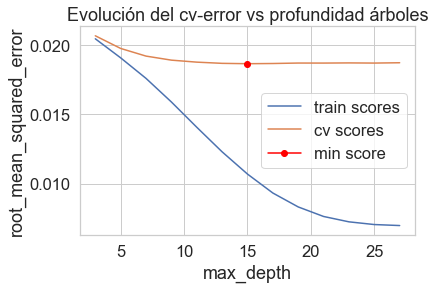

In [46]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_depths = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, None]

# Bucle para entrenar un modelo con cada valor de max_depth y extraer su error
# de entrenamiento y de k-cross-validation.
for max_depth in max_depths:
    
    modelo =  RandomForestRegressor(
            n_estimators = 796,
            criterion    = 'mse',
            max_depth    = max_depth,
            max_features = 7,
            oob_score    = True,
            n_jobs       = -1,
            random_state = 42
            )
    
    # Error de train
    modelo.fit(X_train_prep, y_train_prep)
    predicciones = modelo.predict(X = X_train_prep)
    rmse = mean_squared_error(
            y_true  = y_train_prep,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train_prep,
                y         = y_train_prep,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5,
                n_jobs    = -1
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_depths, train_scores, label="train scores")
ax.plot(max_depths, cv_scores, label="cv scores")
ax.plot(max_depths[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_depth")
ax.set_title("Evolución del cv-error vs profundidad árboles")
plt.legend();
print(f"Valor óptimo de max_depth: {max_depths[np.argmin(cv_scores)]}")

In [47]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': range(800, 900, 5),
              'max_features': [1.0, 'sqrt', 5, 6, 7],
              'max_depth'   : [None, 14, 15, 16]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestRegressor(random_state = 42),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = -1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_prep, y = y_train_prep)
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
340,16,5,800,-0.018574,0.000445,-0.010186,0.000092
341,16,5,805,-0.018574,0.000446,-0.010184,0.000092
342,16,5,810,-0.018575,0.000445,-0.010184,0.000092
343,16,5,815,-0.018575,0.000446,-0.010183,0.000092


In [48]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': 16, 'max_features': 5, 'n_estimators': 800} : -0.018574025948340036 neg_root_mean_squared_error


In [49]:
# Error de test del modelo final
# ==============================================================================
modelo_rf = grid.best_estimator_
y_pred = modelo_rf.predict(X = X_test_prep)
y_pred = inv_box_cox_transform(y_pred, lamda)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 469.66491863435584


In [50]:
# Guardamos los modelos
# ==============================================================================
pickle.dump(modelo_rf, open("../models/my_model_rf.pkl", "wb"))
pickle.dump(modelo_histgb, open("../models/my_model_histgb.pkl", "wb"))

Aquí podemos ver que nuestros modelos tienen un error muy parecido, faltaría ver el comportamiento de los residuos pero antes vamos a probar con una técnica de modelado que combina varios modelos con el objetivo de mejorar el modelo final.

Esta estrategia se basa en la asunción de que, distintos modelos entrenados independientemente, emplean distintos aspectos de los datos para realizar las predicciones, es decir, cada uno es capaz de identificar parte de la “verdad” pero no toda ella. Combinando la perspectiva de cada uno de ellos, se obtiene una descripción más detallada de la verdadera estructura subyacente en los datos.

## Algoritmo Super-Learner

In [51]:
modelo_rf = pickle.load(open("../models/my_model_rf.pkl", "rb"))
modelo_histgb = pickle.load(open("../models/my_model_histgb.pkl", "rb"))

In [52]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [('rf', modelo_rf), ('histgb', modelo_histgb)]

modelo_stacking = StackingRegressor(
        estimators = estimators,
        final_estimator = RidgeCV(),
        cv = 5,
        n_jobs = -1
        )

modelo_stacking.fit(X_train_prep, y_train_prep)

y_pred = modelo_stacking.predict(X = X_test_prep)
y_pred = inv_box_cox_transform(y_pred, lamda)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
        )

print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 478.0785120787303


Parece que para nuestro dataset esta combinación de modelos no es la mejor, veamos como se comportan los residuos en nuestros modelos.

## Diagnóstico de los residuos

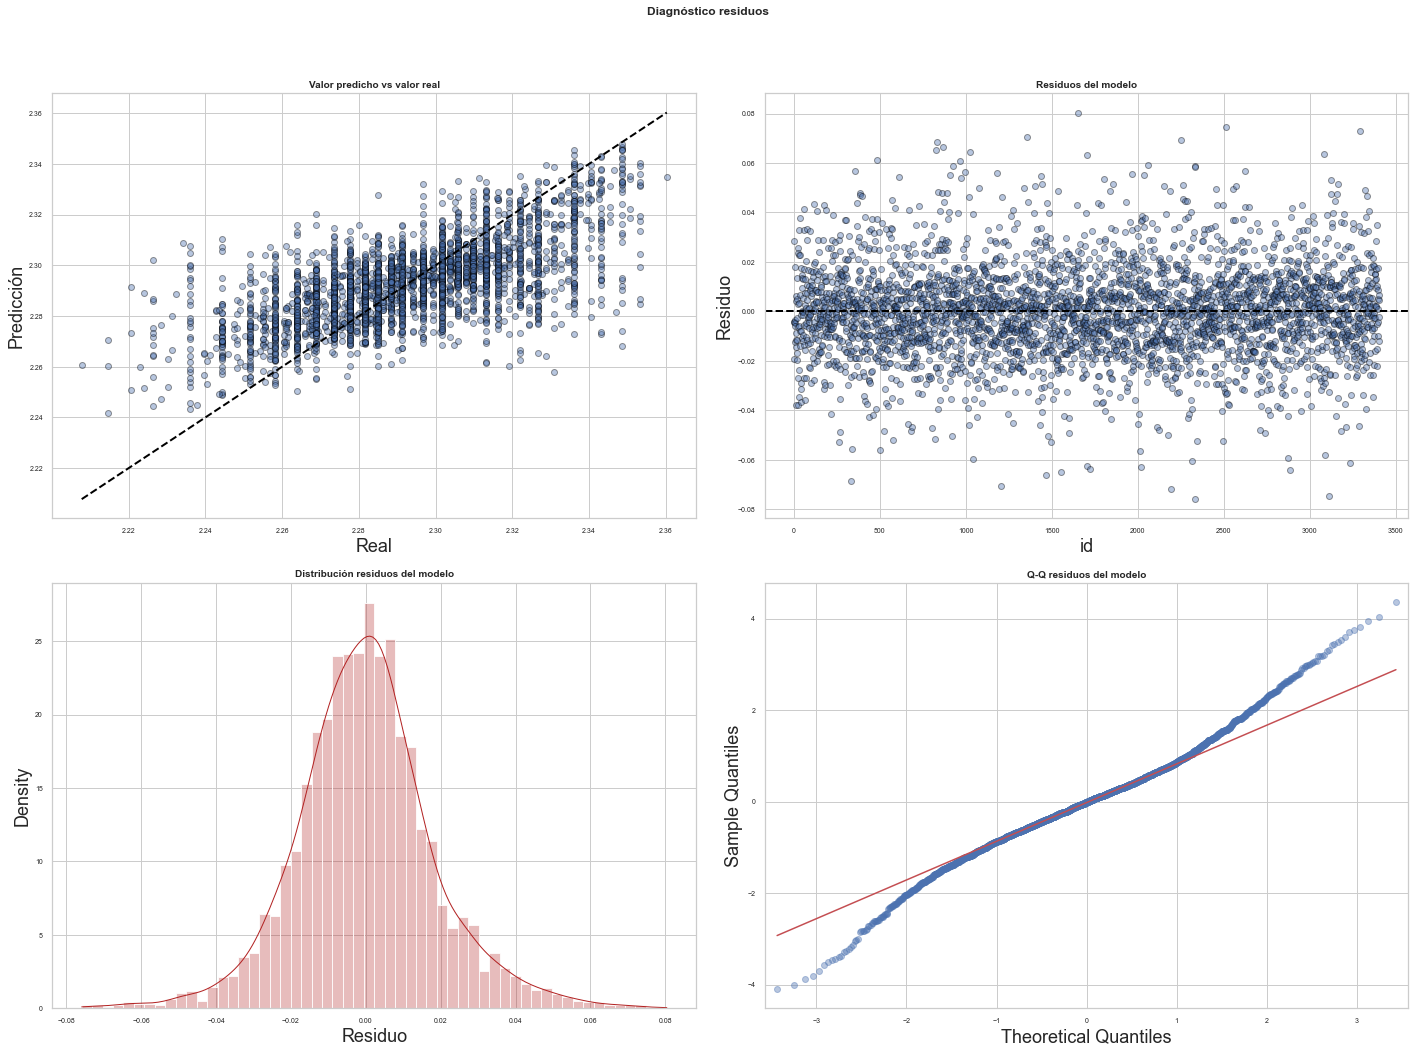

In [53]:
# Diagnóstico del modelo Random Forest Regressor
# ==============================================================================
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
import statsmodels.api as sm

cv = KFold(n_splits=10, random_state=42, shuffle=True)

# Validación cruzada
# ==============================================================================
cv_prediccones = cross_val_predict(
        estimator = modelo_rf,
        X         = X_train_prep,
        y         = y_train_prep,
        cv        = cv,
        method    = 'predict',
        n_jobs    = -1
        )

# Gráfico error de validación cruzada
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

axes[0, 0].scatter(y_train_prep, cv_prediccones, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train_prep.min(), y_train_prep.max()], [y_train_prep.min(), y_train_prep.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train_prep))), y_train_prep - cv_prediccones,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = y_train_prep - cv_prediccones,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    y_train_prep - cv_prediccones,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

In [54]:
# Test de normalidad de los residuos
# ==============================================================================
from scipy.stats import shapiro

residuos = y_train_prep - cv_prediccones
stat, p = shapiro(residuos)

if p > 0.05:
    print("Los residuos son normalmente distribuidos")
else:
    print("Los residuos no son normalmente distribuidos")

Los residuos no son normalmente distribuidos


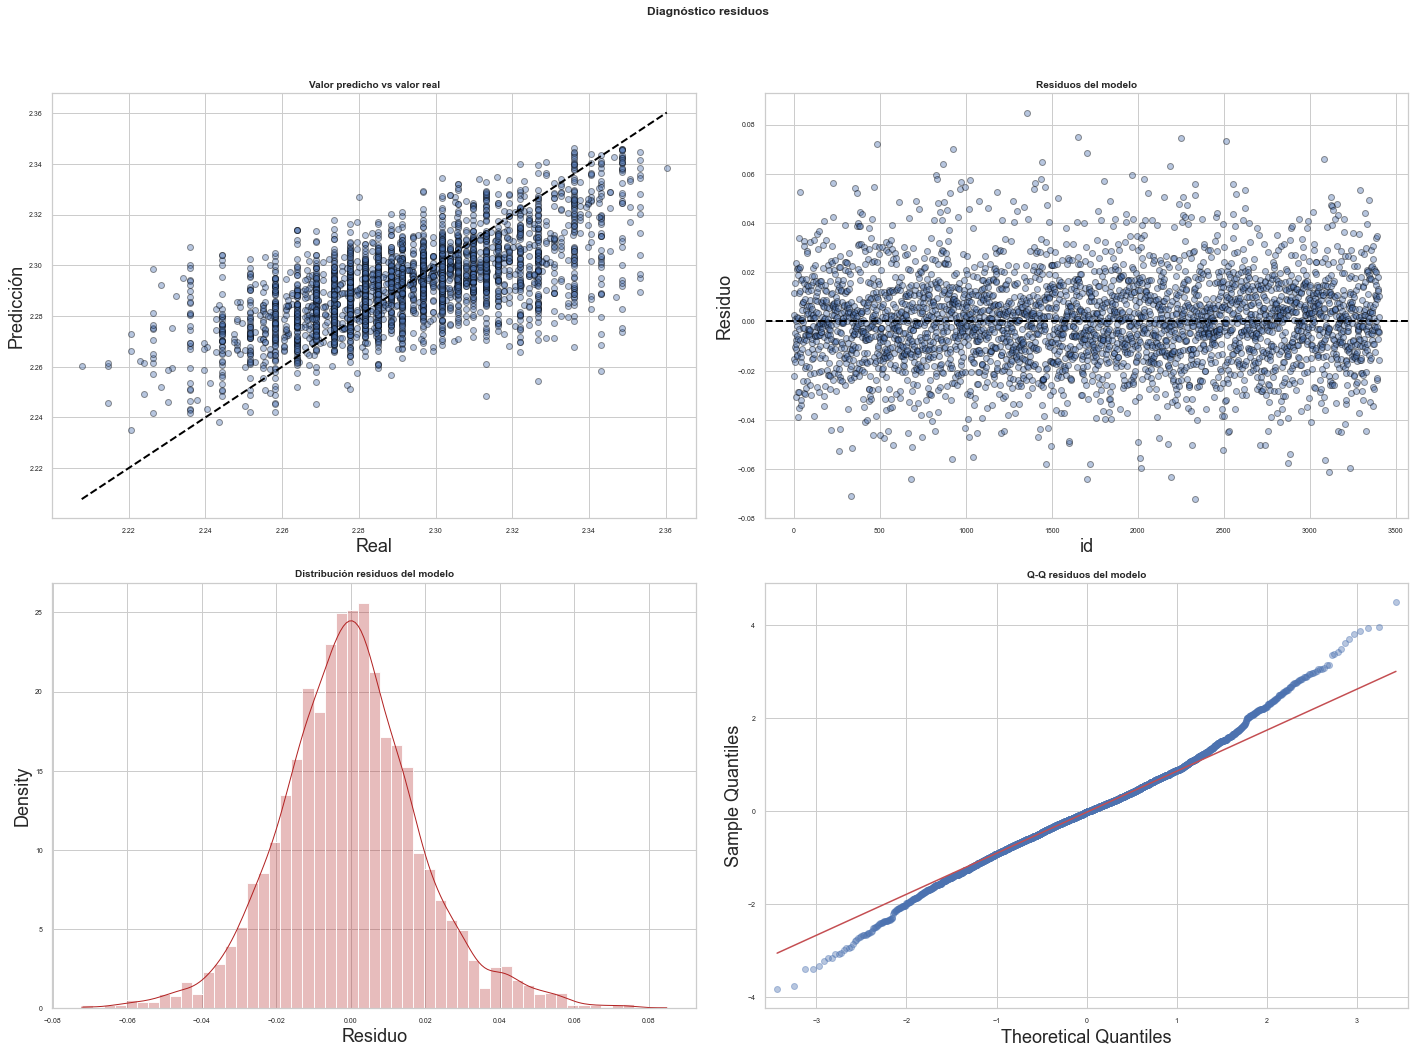

In [55]:
# Diagnóstico del modelo Histogram Gradient Boosting Regressor
# ==============================================================================
# Validación cruzada
# ==============================================================================
cv_prediccones = cross_val_predict(
        estimator = modelo_histgb,
        X         = X_train_prep,
        y         = y_train_prep,
        cv        = cv,
        method    = 'predict',
        n_jobs    = -1
        )

# Gráfico error de validación cruzada
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

axes[0, 0].scatter(y_train_prep, cv_prediccones, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train_prep.min(), y_train_prep.max()], [y_train_prep.min(), y_train_prep.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train_prep))), y_train_prep - cv_prediccones,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = y_train_prep - cv_prediccones,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    y_train_prep - cv_prediccones,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

In [56]:
# Test de normalidad de los residuos
# ==============================================================================
residuos = y_train_prep - cv_prediccones
stat, p = shapiro(residuos)

if p > 0.05:
    print("Los residuos son normalmente distribuidos")
else:
    print("Los residuos no son normalmente distribuidos")

Los residuos no son normalmente distribuidos


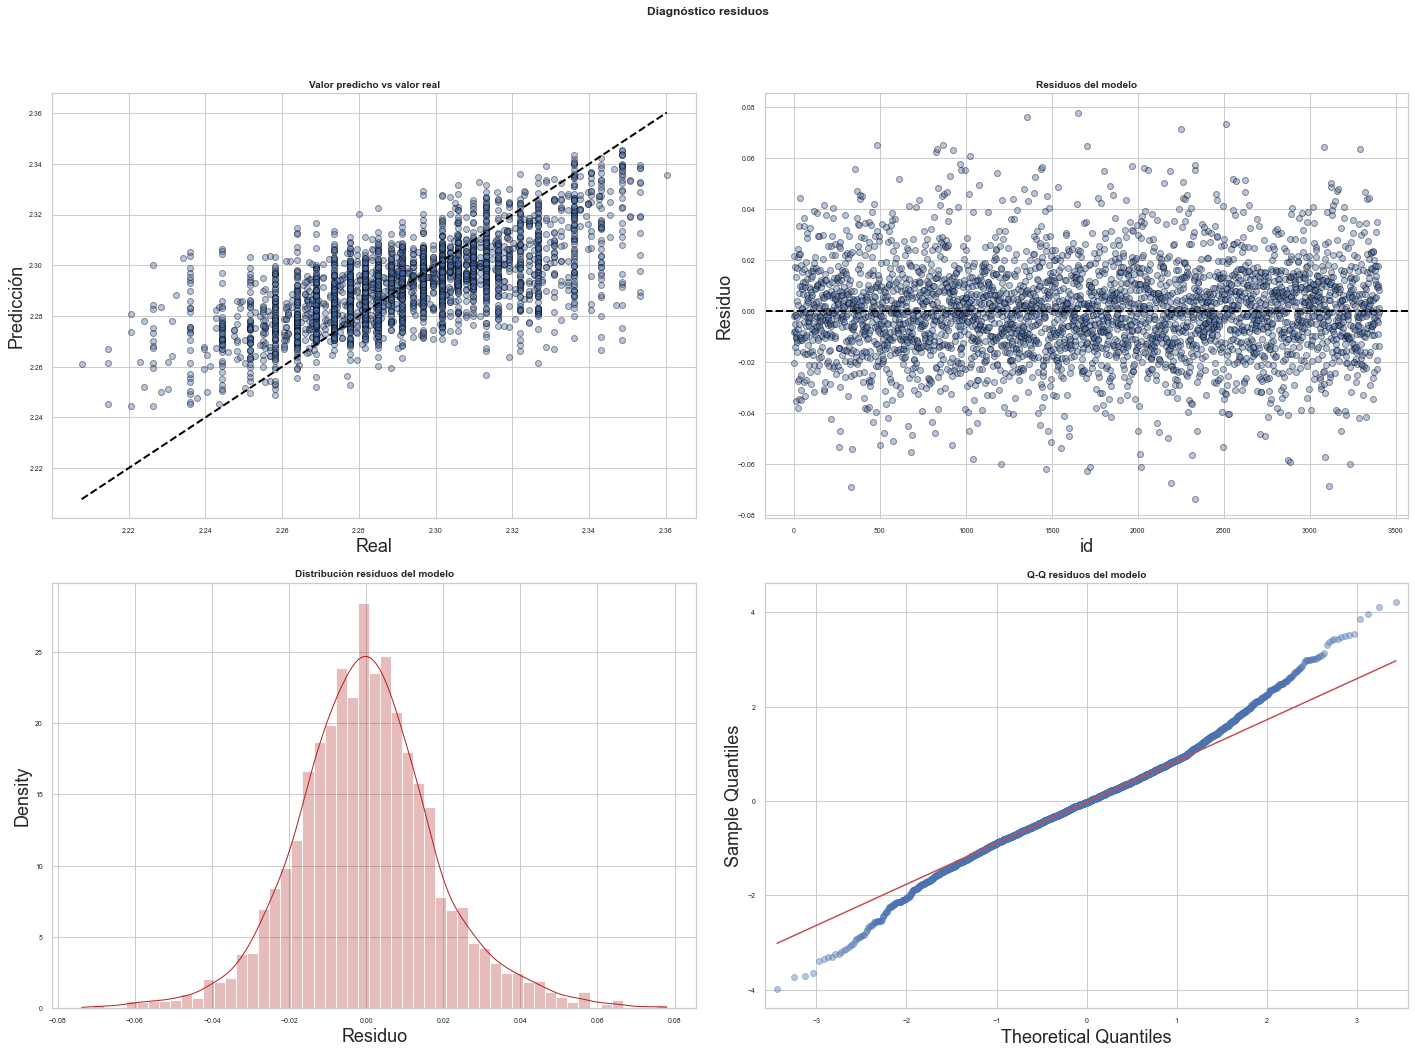

In [57]:
# Diagnóstico del modelo Stacking Regressor
# ==============================================================================
# Validación cruzada
# ==============================================================================
cv_prediccones = cross_val_predict(
        estimator = modelo_stacking,
        X         = X_train_prep,
        y         = y_train_prep,
        cv        = cv,
        method    = 'predict',
        n_jobs    = -1
        )

# Gráfico error de validación cruzada
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

axes[0, 0].scatter(y_train_prep, cv_prediccones, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train_prep.min(), y_train_prep.max()], [y_train_prep.min(), y_train_prep.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train_prep))), y_train_prep - cv_prediccones,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = y_train_prep - cv_prediccones,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    y_train_prep - cv_prediccones,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

In [58]:
# Test de normalidad de los residuos
# ==============================================================================
residuos = y_train_prep - cv_prediccones
stat, p = shapiro(residuos)

if p > 0.05:
    print("Los residuos son normalmente distribuidos")
else:
    print("Los residuos no son normalmente distribuidos")

Los residuos no son normalmente distribuidos


In [59]:
# Error de porcentaje cuadrático medio
# ==============================================================================
print("Porcentaje de MSE: ", mean_squared_error(y_train_prep, cv_prediccones) / np.var(y_train_prep))

Porcentaje de MSE:  0.5598839903291244


## Conclusiones

* Se necesitan más datos para mejorar el modelo final, pueden ser mayor cantidad de anuncios o más características que las que tenemos en nuestro dataset (por ejemplo, fotos publicadas en el anuncio).
* No se pueden crear clusters que distribuyan los precios de alquiler con las características de los anuncios de nuestro dataset.
* La media de precios de alquiler en nuestro dataset es aproximadamente mayor a los 1000€, con datos tomados durante el verano de 2022
* El modelo seleccionado como mejor es el Random Forest Regressor, con una profundidad máxima por arbol de 16, con 5 features seleccionadas para la predicción, y 800 arboles estimadores.


Gracias por leer este artículo.

*Carlos I. Cabruja Rodil*